In [1]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import random

class Particle():
    
    def __init__(self, mass, location, charge, velocity):
        self.mass = mass
        self.location = location
        self.charge = charge
        self.velocity = velocity
        
    def calculate_distance(self):
        return np.linalg.norm(self.location)
    
    def coulomb_force(self, target_particle_charge, r): 
        return (self.charge * target_particle_charge) / (4 * pi * 8.854e-12 * r**2)

In [2]:
TIME_STEP = 1e-23

alpha_particle_mass = 6.644e-27
alpha_particle_charge = 3.204e-19
target_particle_charge = 79 * 1.602e-19
target_particle_mass = 197 * 1.661e-27
target_location = np.array([0, 0])
target_velocity = np.array([0, 0])

target = Particle(alpha_particle_mass, target_location, target_particle_charge, target_velocity)

In [35]:
def simulation_loop(alpha):
    
    history = []
    closest_distance = 1
    closest_location = np.array([])
    
    while (alpha.location[0] >= -2e-14 and alpha.location[0] < 2e-14):
        
        history.append(alpha.location)
        
        distance = alpha.calculate_distance()
        if distance < closest_distance:
            closest_distance = distance
            closest_location = alpha.location
        
        angle_psi = np.arctan(alpha.location[1] / -alpha.location[0])
        
        force = alpha.coulomb_force(target.charge, distance)
      
        acting_velocity = TIME_STEP * force / alpha.mass
        velocity_x = acting_velocity * np.cos(angle_psi)
        
        if alpha.location[0] < 0:
            velocity_x = -1.0 * velocity_x
            
        velocity_y = acting_velocity * np.sin(angle_psi)
        
        acting_velocity = np.array([velocity_x, velocity_y])
        alpha.velocity = alpha.velocity + acting_velocity
        
        movement_x = alpha.velocity[0] * TIME_STEP
        movement_y = alpha.velocity[1] * TIME_STEP
        movement = np.array([movement_x, movement_y])
        
        alpha.location = alpha.location + movement
        alpha.velocity = alpha.velocity + movement
        
    return history, closest_location

In [36]:
def calculating_scattering_angle(closest_approach,alpha, b):
    
    #we split the closest approach into x and y components
    closest_y = closest_approach[1]
 
    #if the x component is negative we make it positive
    if closest_approach[0] < 0:
        closest_x = -1 * closest_approach[0]
    else:
        closest_x = closest_approach[0]
 
    #we split the final location of the alpha particle into x and y components
    end_loc_y = alpha.location[1]
 
    #if the x component is negative we make it positive
    if alpha.location[0] < 0:
        end_loc_x = -1 * alpha.location[0]
    else:
        end_loc_x = alpha.location[0]
 
    #calculates angle psi of the closest approach of alpha particle - returns radians
    psi_of_closest_approach = np.arctan(closest_y/closest_x)
 
    #finding the point where the line between closest approach and target nuclei intercepts with b
    intersection_y = b
    
    #np.tan() takes in rad
    intersection_x = intersection_y/np.tan(psi_of_closest_approach)
    intersection_location = np.array([intersection_x, intersection_y])
 
    #since we can't divide by 0, if it bounces straight back we hardcode the scattering angle to 0
    if end_loc_y == 0:
        scattering_angle = 180
    else: 
        20
 
    #finds difference between intersection point and final alpha location
    difference_x = end_loc_x - intersection_location[0]
    difference_y = end_loc_y - intersection_location[1]
 
    #calculates scattering angle
    scattering_angle = np.arctan(difference_y/difference_x)
 
    #converts to degrees from radians
    scattering_angle = np.rad2deg(scattering_angle)
    
    #if the alpha particle bounces back it returns 180 - scattering angle
    if alpha.location[0] < closest_approach[0]:
        scattering_angle = 180 - scattering_angle
    
    #for case when end_loc x is negative as well as closest approach x but end_lox x is bigger
    if scattering_angle < 0:
        scattering_angle = scattering_angle *-1
 
    return scattering_angle

In [37]:
def plot_prepare_trajectory(history):
    x_loc = []
    y_loc = []
 
    for i in history:
        x_loc.append(i[0])
        y_loc.append(i[1])

    return x_loc, y_loc 

In [38]:
def simulater(alpha, b):
    history, closest_approach = simulation_loop(alpha)
    scattering_angle = calculating_scattering_angle(closest_approach, alpha, b)
    return scattering_angle, history, closest_approach

#converts MeV to Joules
def mev_to_vel(mev, mass):
    joule = mev * 1.6022E-13
    velocity = np.sqrt(joule/(0.5*mass))
    return velocity

def myround(x, base=15):
    return base * round(x/base) 

In [39]:
def main_trajectory(number_of_alpha_particles=10, b_max=1e-14, target_proton_num=79, mev=7.7):
    start_velocity = mev_to_vel(mev, alpha_particle_mass)
    target.charge = target_proton_num * 1.6e-19
    
    plt.figure(figsize=(10,10))
    plt.style.use('ggplot')
 
    #plotting target nucleus
    plt.plot(0,0, marker = 'o')
    
    for i in range(number_of_alpha_particles):
        #selecting y distance (impact parameter) range to randomly initialize particles from
        b = np.random.uniform(0,5)*(b_max)
 
        #start location in meters
        alpha_start_location = np.array([-2e-14,b])
        alpha_start_velocity = np.array([start_velocity- alpha_start_location[0], b])
        alpha = Particle(alpha_particle_mass, alpha_start_location, alpha_particle_charge, alpha_start_velocity)
 
        #first alpha particle
        scattering_angle, history, closest_approach = simulater(alpha, b)
 
        x_loc, y_loc = plot_prepare_trajectory(history)
        plt.plot(x_loc, y_loc, '--',label=f'{i+1}')
        
    plt.legend()
    plt.title('Alpha Particle Trajectory')
    plt.ylabel('Y distance - impact parameter - (m e-14)')
    plt.xlabel('X distance (m e-14)')
    plt.tight_layout()
    ax = plt.gca()
    ax.set_ylim([-5e-14,5e-14])
    ax.set_xlim([-2.1e-14, 2e-14])

    plt.grid(True)
    plt.show() 

In [69]:
def main_r_formula(number_of_alpha_particles=1000, b_max=1e-13, target_proton_num=79, mev=7.7, label='Data points'):
       
    global alpha_particle_mass
 
    #calcualtes the start x velocity of alpha particle
    start_velocity = mev_to_vel(mev, alpha_particle_mass)
 
    #calculates the charge of the target in joules
    target.charge = target_proton_num * 1.6e-19
 
    plt.figure(figsize=(10,10))
    plt.style.use('ggplot')
 
    #counts for the scattering angle rounded to nearest 15 degrees
    scattering_angle_count = {0: 0, 15: 0, 30: 0, 45: 0, 60: 0, 75: 0, 90: 0, 105: 0, 120: 0, 135: 0, 150: 0, 165:0, 180: 0}
 
    #counts for the scattering angle rounded to nearest 60 degrees - this is used later for quantitative analysis
    scattering_angle_count_grouped = {0: 0,60: 0,120: 0, 180: 0}
 
    for i in range(number_of_alpha_particles):
        b = np.random.uniform(0,1)*(b_max)
        #start location in meters
        alpha_start_location = np.array([-2e-14,b])
 
        #velocity at the start of the experiment
        alpha_start_velocity = np.array([start_velocity - alpha_start_location[0], b])
 
        #initializing the particle
        alpha = Particle(alpha_particle_mass, alpha_start_location, alpha_particle_charge, alpha_start_velocity)
 
        #first alpha particle
        scattering_angle, history, closest_approach = simulater(alpha, b) # passing the first particle
 
        #rounding to nearest 15 degrees
        rounded_scattering_angle = myround(scattering_angle)
        higher_rounded_scattering_angle = myround(scattering_angle, base=60)
 
        #adding to count
        scattering_angle_count[rounded_scattering_angle] = scattering_angle_count[rounded_scattering_angle] + 1
 
        #adding to count
        scattering_angle_count_grouped[higher_rounded_scattering_angle] = scattering_angle_count_grouped[higher_rounded_scattering_angle] + 1
 
        #shows the user how many particles have been sent
        print(f'{i+1} particles fired')
 
    #gets values from scattering angle dictionary
    angles = list(scattering_angle_count.keys())
    count = list(scattering_angle_count.values())
 
    #gets count from dictionary rounded to nearest 60 degrees
    rounded_count = list(scattering_angle_count.values())
    rounded_count_grouped = list(scattering_angle_count_grouped.values())
 
    #plots number of particles against scattering angle
    plt.plot(angles, count, marker = 'o', label=label)
    plt.title("Number of alpha particles scattered against scattering angle (Rutherford's Formula)")
    plt.ylabel('Number of alpha particles')
    plt.xlabel('Scattering angles (rounded to nearest 15)')
    plt.legend() 

    plt.tight_layout()

    plt.grid(True)
    plt.show()

    return rounded_count, rounded_count_grouped

In [76]:
def test(number_of_alpha_particles=1000, target_proton_num=79, mev=7.7):
    
    #atoms per unit volume gold
    n = 1
 
    #thichness of target (we only have one nucleus) in meters
    L = 1.2e-15 * 5.8
 
    #electron charge
    e = -1.60217663e-19
 
    #coulombs constant
    k = 8.99e9
 
    #atomic number of target
    Z = target_proton_num
 
    #kinetic energy of particle in mev
    KE = mev
 
    #total fired
    Ni = number_of_alpha_particles
 
    #distance to detector
    r = 2e-14
    
    scattering_counts = []
 
    #goes through angles 0-180 in steps of 60
    for i in range(0,240,60):

        #converts the degrees into radians
        scattering_angle = np.deg2rad(i)
 
        #since the formula won't work with 0, and the angle never is truely 0
        if i==0:
            N = (Ni * n * L * Z**2 * k**2 * e**4) / (4 * r**2 * KE**2 * (np.sin((0.5)/2))**4) 
 
        #we plug in the values here: all SI units
        else:
            N = (Ni * n * L * Z**2 * k**2 * e**4) / (4 * r**2 * KE**2 * (np.sin(scattering_angle/2))**4)
 
        scattering_counts.append([i, N])
            
    total = 0
    
    #adds solutions to total
    for i in scattering_counts:
        total+=i[1]
 
    #creates a factor so that the total = Ni
    factor = total/Ni
    
    #uses factor and we get new results
    for i in scattering_counts:
        i[1] = i[1]/factor

    #rounded to nearest whole number
    i[1] = round(i[1])
    counts = []
 
    #we add the factored counts to the counts array
    for i in scattering_counts:
        counts.append(i[1])

    angles = [0,60,120,180]
 
    simulation_count, simulation_count_grouped = main_r_formula(number_of_alpha_particles=1000, b_max=3.1e-13, target_proton_num=79,mev=7.7, label='Simulation results')
    
    #width of bar
    w = 0.4
            
    #plots the results
    bar1 = np.arange(len(angles))
    bar2 = [i+w for i in bar1]
    plt.bar(bar1, counts, width = w, label = "Rutherford's formula",align="center")
    plt.bar(bar2, simulation_count_grouped, width = w, label = "Simulation results",align="center")
    plt.xticks(bar1 + w/2, angles)
 
    plt.legend()
    plt.xlabel('Angles (degrees)')
    plt.ylabel('Number of particles')
 
    print(f'Expected: {counts}')
    print(f'Observed: {simulation_count_grouped}')
 
    plt.title('Comparison between expected results and observed results')
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show() 

In [77]:
def compare(number_of_alpha_particles=1000, b_max=1e-13, target_proton_num=79, mev=7.7, label = '1',number_of_alpha_particles1=1000, b_max1=1e-13, target_proton_num1=79, mev1=7.7, label1 ='2',title='Comparison'):
    
    angles = [0,15,30,45,60,75,90,105,120,135,150,165,180]
 
    one, oneg = main_r_formula(number_of_alpha_particles, b_max, target_proton_num, mev)
    two, twog = main_r_formula(number_of_alpha_particles1, b_max1, target_proton_num1, mev1)
    plt.plot(angles, one, marker = 'o', label = label)
    plt.plot(angles, two, marker = 'o', label = label1)
    plt.title(title)
    plt.ylabel('Number of alpha particles')
    plt.xlabel('Scattering angles (rounded to nearest 15)')
    plt.legend()
    plt.show() 

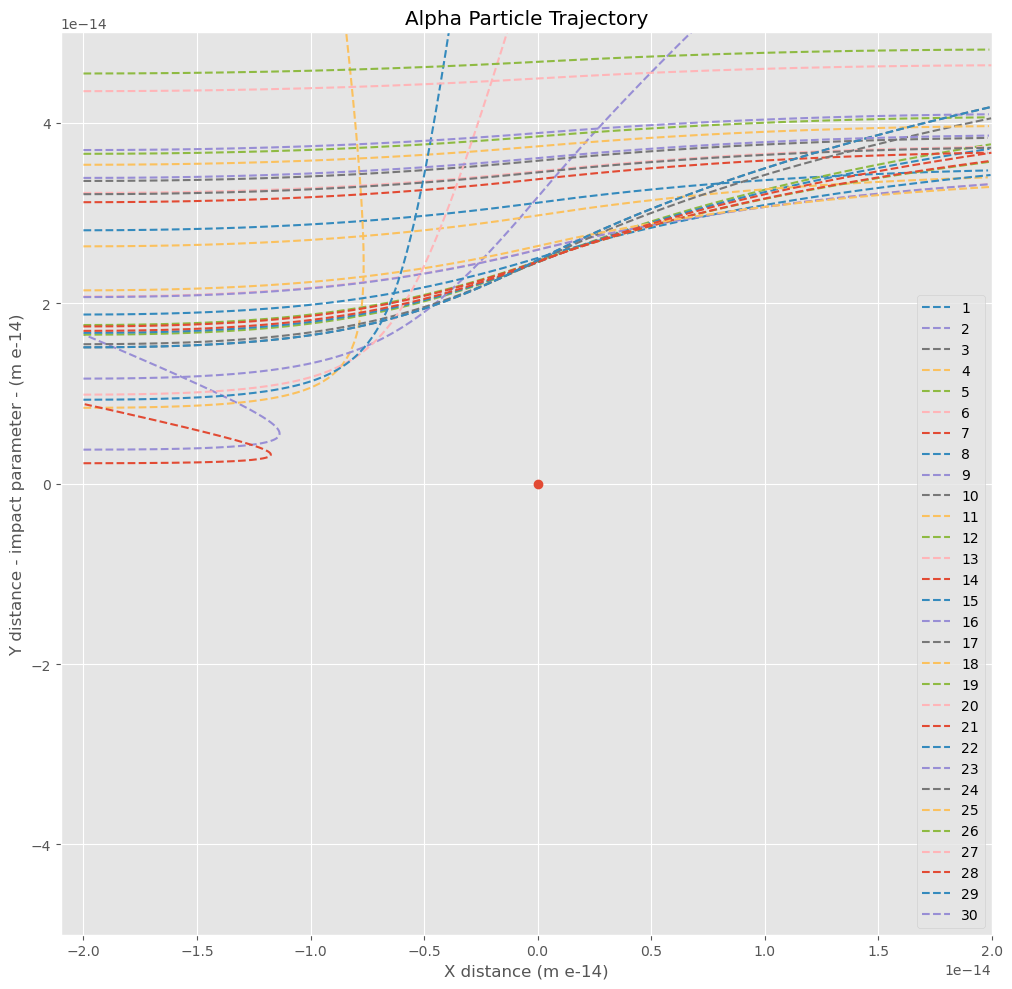

In [78]:
main_trajectory(number_of_alpha_particles=30, b_max=1e-14, target_proton_num=79, mev=7.7)

1 particles fired
2 particles fired
3 particles fired
4 particles fired
5 particles fired
6 particles fired
7 particles fired
8 particles fired
9 particles fired
10 particles fired
11 particles fired
12 particles fired
13 particles fired
14 particles fired
15 particles fired
16 particles fired
17 particles fired
18 particles fired
19 particles fired
20 particles fired
21 particles fired
22 particles fired
23 particles fired
24 particles fired
25 particles fired
26 particles fired
27 particles fired
28 particles fired
29 particles fired
30 particles fired
31 particles fired
32 particles fired
33 particles fired
34 particles fired
35 particles fired
36 particles fired
37 particles fired
38 particles fired
39 particles fired
40 particles fired
41 particles fired
42 particles fired
43 particles fired
44 particles fired
45 particles fired
46 particles fired
47 particles fired
48 particles fired
49 particles fired
50 particles fired
51 particles fired
52 particles fired
53 particles fired
54

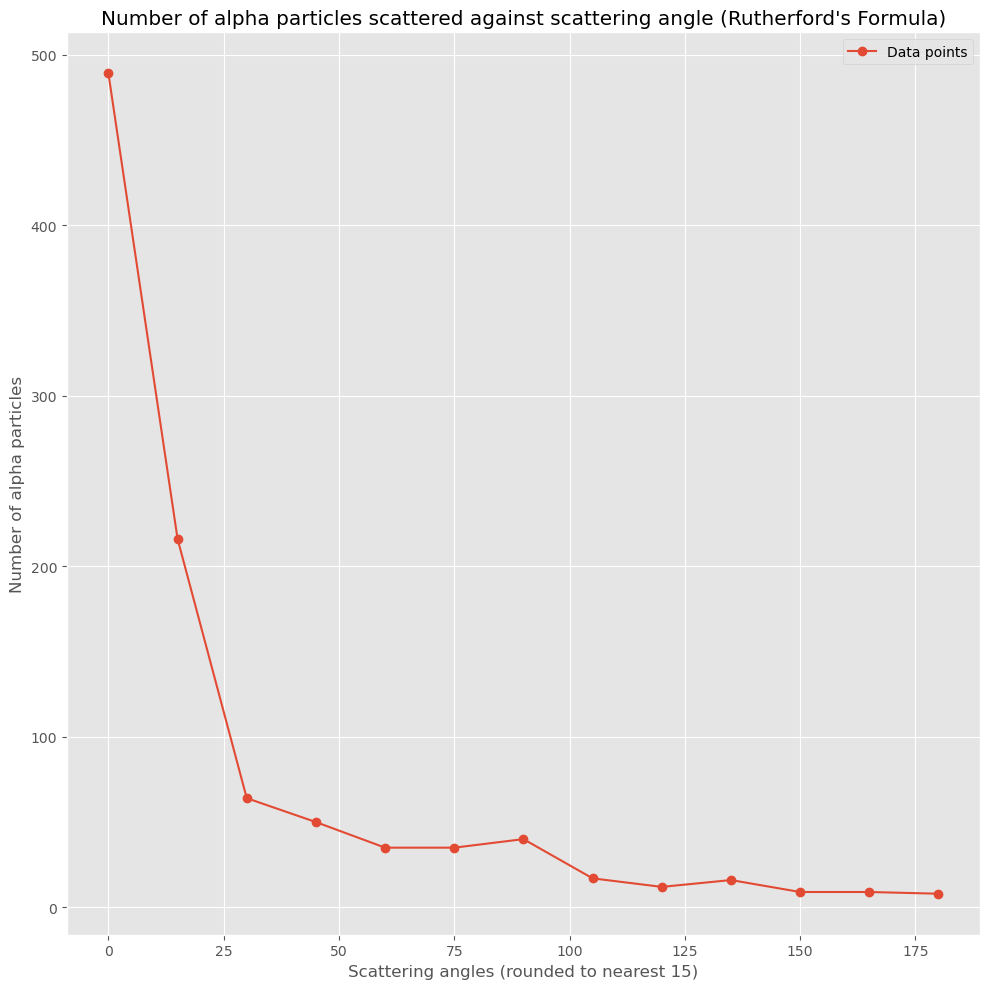

([489, 216, 64, 50, 35, 35, 40, 17, 12, 16, 9, 9, 8], [750, 162, 66, 22])

In [79]:
main_r_formula(number_of_alpha_particles=1000, b_max=1e-13, target_proton_num=79, mev=7.7)

1 particles fired
2 particles fired
3 particles fired
4 particles fired
5 particles fired
6 particles fired
7 particles fired
8 particles fired
9 particles fired
10 particles fired
11 particles fired
12 particles fired
13 particles fired
14 particles fired
15 particles fired
16 particles fired
17 particles fired
18 particles fired
19 particles fired
20 particles fired
21 particles fired
22 particles fired
23 particles fired
24 particles fired
25 particles fired
26 particles fired
27 particles fired
28 particles fired
29 particles fired
30 particles fired
31 particles fired
32 particles fired
33 particles fired
34 particles fired
35 particles fired
36 particles fired
37 particles fired
38 particles fired
39 particles fired
40 particles fired
41 particles fired
42 particles fired
43 particles fired
44 particles fired
45 particles fired
46 particles fired
47 particles fired
48 particles fired
49 particles fired
50 particles fired
51 particles fired
52 particles fired
53 particles fired
54

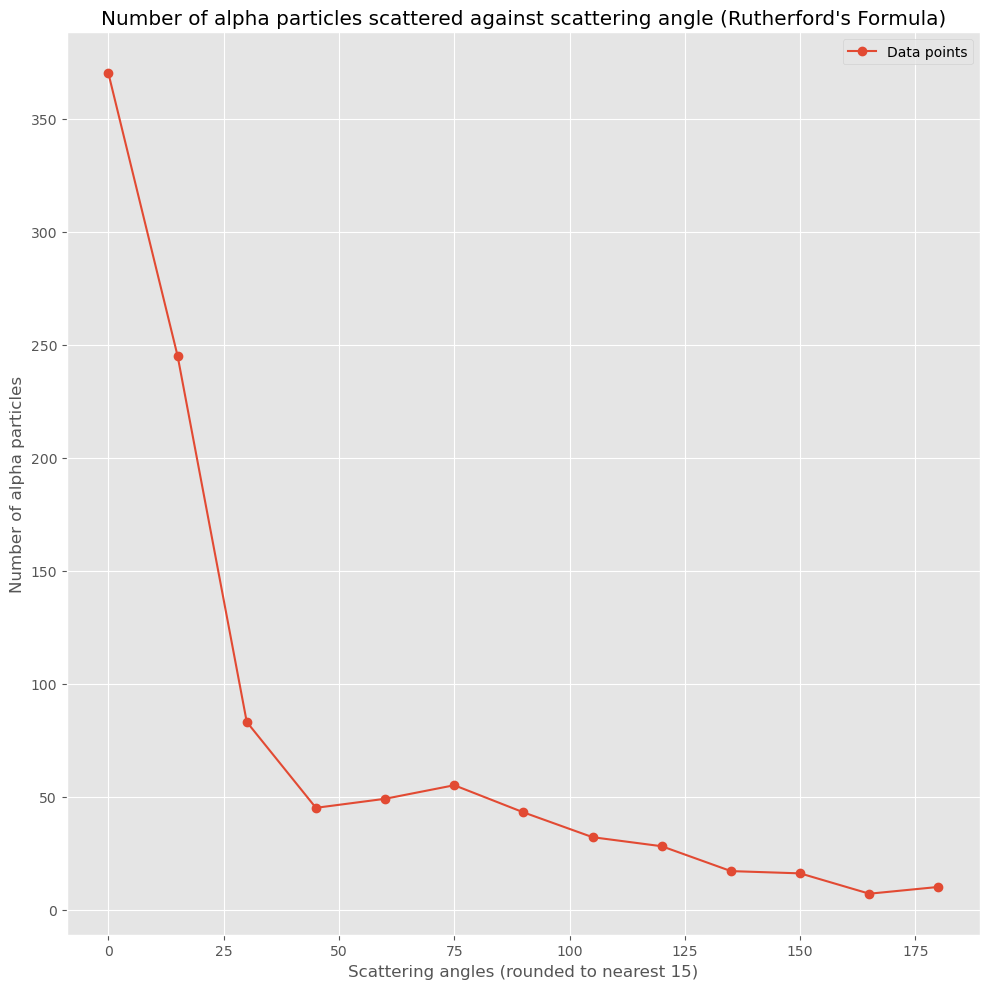

1 particles fired
2 particles fired
3 particles fired
4 particles fired
5 particles fired
6 particles fired
7 particles fired
8 particles fired
9 particles fired
10 particles fired
11 particles fired
12 particles fired
13 particles fired
14 particles fired
15 particles fired
16 particles fired
17 particles fired
18 particles fired
19 particles fired
20 particles fired
21 particles fired
22 particles fired
23 particles fired
24 particles fired
25 particles fired
26 particles fired
27 particles fired
28 particles fired
29 particles fired
30 particles fired
31 particles fired
32 particles fired
33 particles fired
34 particles fired
35 particles fired
36 particles fired
37 particles fired
38 particles fired
39 particles fired
40 particles fired
41 particles fired
42 particles fired
43 particles fired
44 particles fired
45 particles fired
46 particles fired
47 particles fired
48 particles fired
49 particles fired
50 particles fired
51 particles fired
52 particles fired
53 particles fired
54

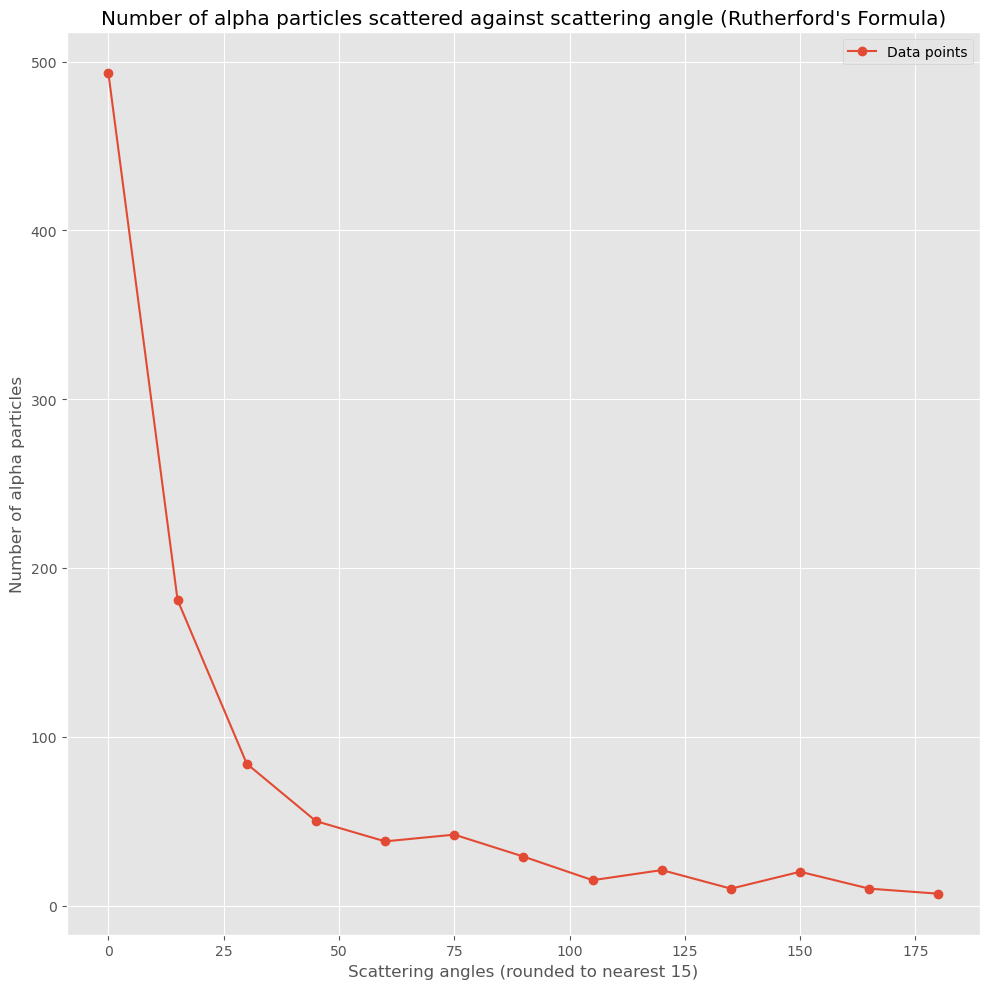

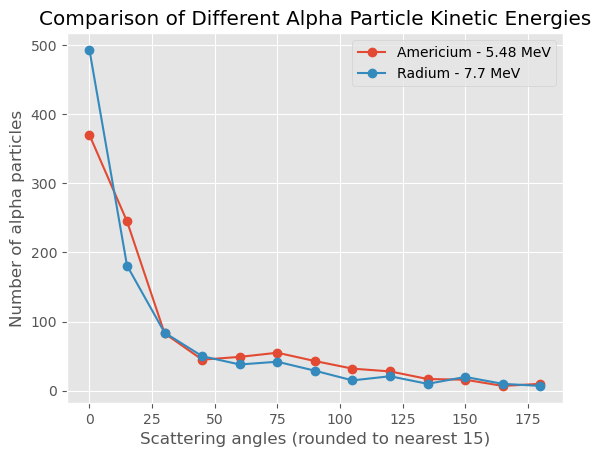

In [80]:
compare(number_of_alpha_particles=1000, b_max=1e-13, target_proton_num=79, mev=5.48, label = 'Americium - 5.48 MeV',number_of_alpha_particles1=1000, b_max1=1e-13, target_proton_num1=79, mev1=7.7, label1 ='Radium - 7.7 MeV',title='Comparison of Different Alpha Particle Kinetic Energies')

1 particles fired
2 particles fired
3 particles fired
4 particles fired
5 particles fired
6 particles fired
7 particles fired
8 particles fired
9 particles fired
10 particles fired
11 particles fired
12 particles fired
13 particles fired
14 particles fired
15 particles fired
16 particles fired
17 particles fired
18 particles fired
19 particles fired
20 particles fired
21 particles fired
22 particles fired
23 particles fired
24 particles fired
25 particles fired
26 particles fired
27 particles fired
28 particles fired
29 particles fired
30 particles fired
31 particles fired
32 particles fired
33 particles fired
34 particles fired
35 particles fired
36 particles fired
37 particles fired
38 particles fired
39 particles fired
40 particles fired
41 particles fired
42 particles fired
43 particles fired
44 particles fired
45 particles fired
46 particles fired
47 particles fired
48 particles fired
49 particles fired
50 particles fired
51 particles fired
52 particles fired
53 particles fired
54

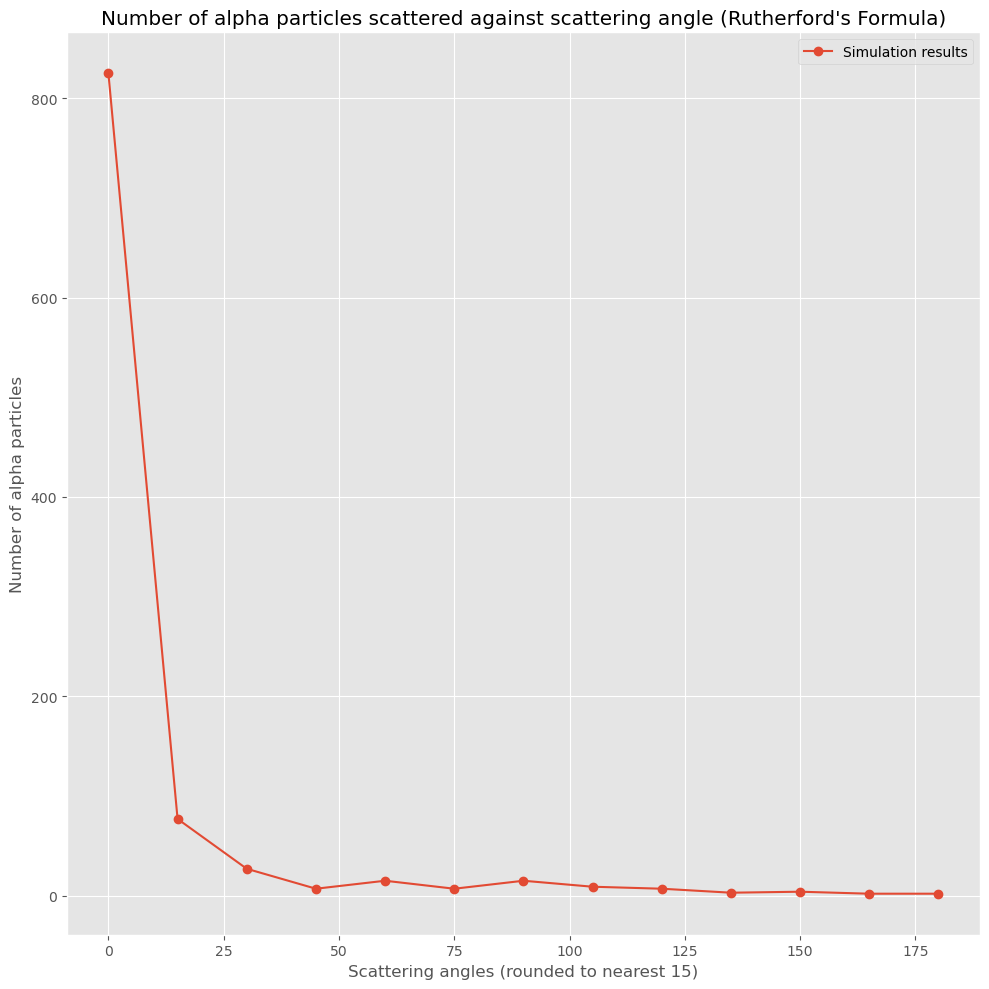

Expected: [934.2728918277382, 56.00416317636484, 6.222684797373871, 4]
Observed: [920, 52, 23, 5]


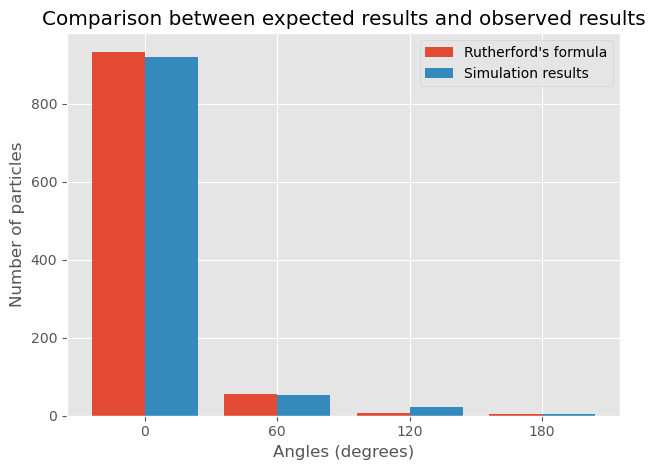

In [81]:
test(number_of_alpha_particles=1000, target_proton_num=79, mev=7.7)